__transfer learning__   
техника использования частей предобученных моделей для решения своих задач

Евгений Борисов <esborisov@sevsu.ru>

---

Sasank Chilamkurthy    Transfer Learning for Computer Vision Tutorial.   
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html   

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# будем строить классификатор, 
# который умеет отделять картинки с пчёлами от картинок с муравьями

https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [1]:
data_dir = 'data/hymenoptera_data'

In [2]:
import torch
from torch.utils.data import DataLoader

In [3]:
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [4]:
# преобразования картинок в тензоры
transforms_train = transforms.Compose([ # augmentation and normalization for training
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
transforms_val = transforms.Compose([ # normalization for validation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [5]:
# данные с преобразованием
data_train = ImageFolder( data_dir+'/train', transforms_train)
data_val = ImageFolder( data_dir+'/val', transforms_val)

# размеры датасетов
data_train_size = len(data_train)
data_val_size = len(data_val)

# имена классов
class_names = data_train.classes

batch_size=64 # количество объектов в одном батче

# формируем батчи
dataloader_train = DataLoader(data_train,batch_size=batch_size,shuffle=True,num_workers=2)
dataloader_val = DataLoader(data_val,batch_size=batch_size,shuffle=True,num_workers=2)

data_train_size,data_val_size, class_names 

(244, 153, ['ants', 'bees'])

In [6]:
# преобразует numpy тензор из датасета в картинки
def tensor2img(t):
    im = np.transpose( t, (0, 2, 3, 1))
    im_mx,im_mn = im.max(axis=(1,2,3),keepdims=1),im.min(axis=(1,2,3),keepdims=1)
    return ((im-im_mn)/(im_mx-im_mn)*255.).astype(np.uint8)

In [10]:
# извлекаем один батч и преобразуем его в картинки
x, y = next(iter(dataloader_train))
x,y = x.detach().numpy(), y.detach().numpy()
x = tensor2img(x)
x.shape, y.shape

((64, 224, 224, 3), (64,))

In [11]:
def draw_images(
        x, # numpy тензор с картинками
        y=[], # метки классов
        class_names=None, # имена классов
        columns=3, # количество колонок в таблице с картинками  
        fig_width=14, # ширина таблицы с картинками
        num_ex=0, # рисуем только первые num_ex
        max_title_len=25 # максимальная длинна заголовка картинки
    ):
    # рисуем данные
    n_img = min(x.shape[0],num_ex) if num_ex>0 else x.shape[0]  # количество картинок для отображения
    col = columns # количество колонок
    w = fig_width # ширина таблицы с картинками
    h = (n_img//col)*(w//col) # высота таблицы с картинками

    fig = plt.figure(figsize=(w,h))
    for n in range(n_img):
        img = x[n,:] # извлекаем одну картинку
        plt.subplot(n_img//col+1,col,n+1) # создаём ячейку таблицы
        plt.axis(False) # оси координат не рисуем
        if len(y)==x.shape[0]:
            t = class_names[y[n]] # имя класса картинки
            t = t if len(t)<(max_title_len+1) else t[:max_title_len]+'...'
            plt.title(t) # заголовок картинки
        plt.imshow(img) # рисуем картинку
    fig.tight_layout() # выравниваем элементы таблицы


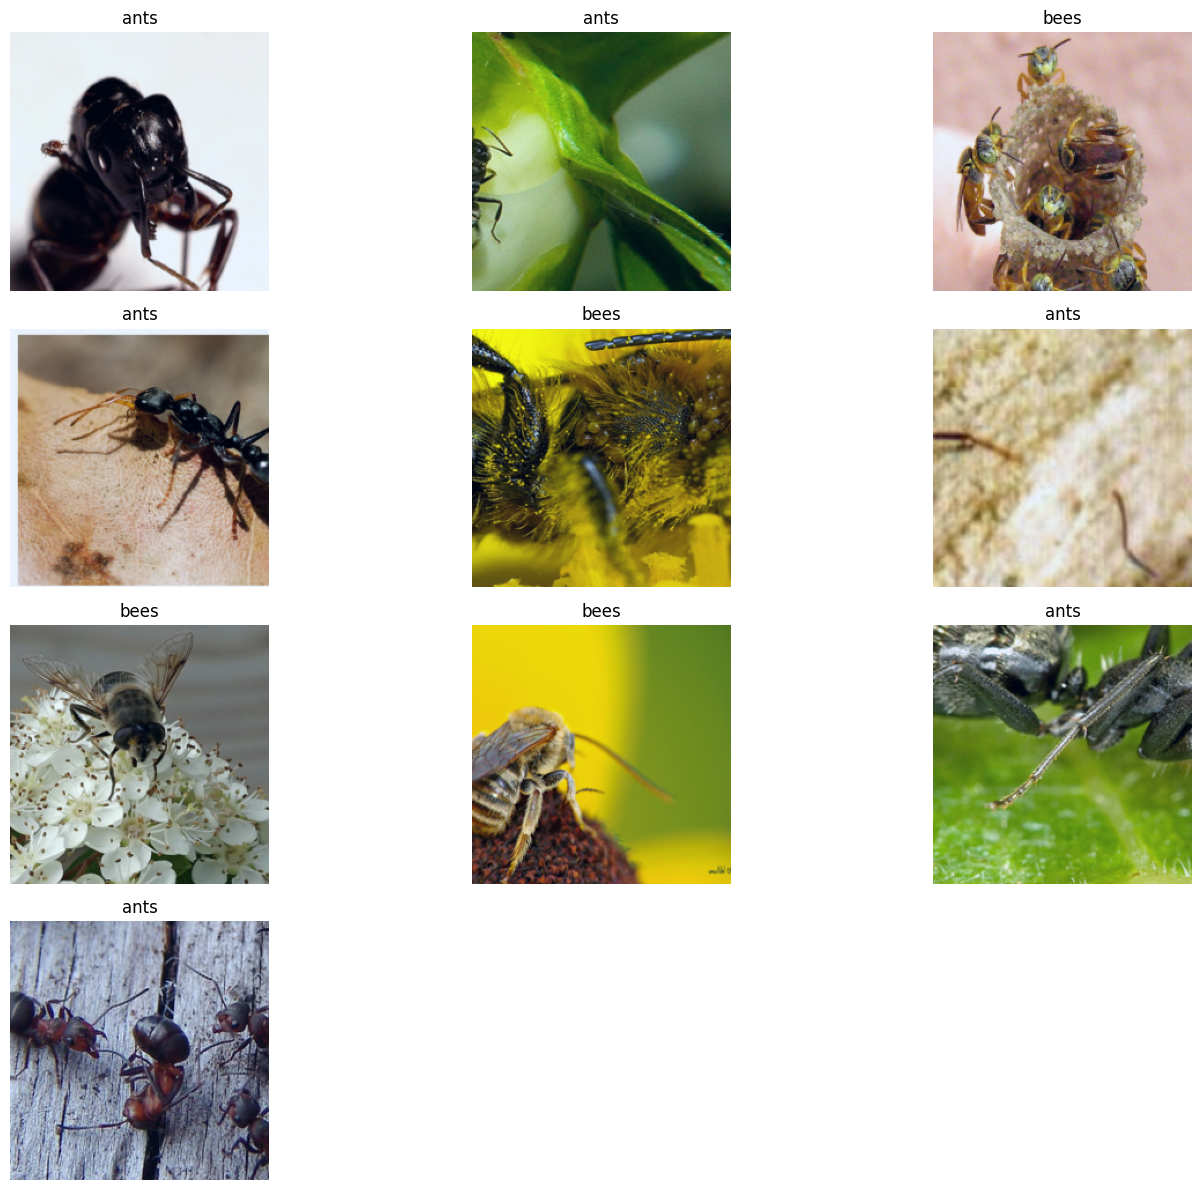

In [12]:
draw_images(x,y,class_names,num_ex=10)

---

In [13]:
# подгружаем предобученный классификатор картинок ResNet
from torchvision.models import resnet18

model = resnet18(pretrained=True)

# фиксируем веса модели, дообучать их не будем
for param in model.parameters():
    param.requires_grad = False

/opt/venv/jupyter_1/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/venv/jupyter_1/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/mechanoid/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [

In [14]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# import torch.nn as nn
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax

In [16]:
# заменяем последний слой на новый классификатор

num_ftrs = model.fc.in_features # размер слоя, который будем заменять

# новый классфикатор - двуслойный MLP с выходом Softmax
model.fc = Sequential(
    Linear(num_ftrs, 256),
    ReLU(),
    Linear(256, len(class_names)), # два класса
    Softmax(dim=1)
)

In [17]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# перемещаем модель на device

# device = 'cpu'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [19]:
from torch.nn import CrossEntropyLoss 
from torch.optim import SGD
from torch.optim import lr_scheduler

In [20]:
criterion = CrossEntropyLoss() # функция потери 
optimizer = SGD(model.fc.parameters(), lr=.01, momentum=0.2) # метод обучения

# будем уменьшать скорость обучения в процессе
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

In [21]:
# обучающий проход по всем батчам учебного датасета
def train_epoch(
        model=model, # модель для обучения
        dataloader=dataloader_train, # батчи учебного датасета
        dataset_size = data_train_size, # общее количество примеров учебного датасета
        criterion = criterion, # функция потери
        optimizer=optimizer, # метод обучения
    ):
    
    train_loss = .0 # среднее значение потери 
    train_acc = .0 # средняя погрешность 
    
    model.train() # режим обучения
    for inputs, labels in dataloader: # для всех батчей датасета
        # перемещаем батч на device
        inputs,labels  = inputs.to(device), labels.to(device) 
        optimizer.zero_grad() # обнуляем значение градиентов
        outputs = model(inputs) # считаем выход модели на батче, прямой проход
        loss = criterion(outputs, labels) # значение потери на батче
        loss.backward() # обратный проход
        optimizer.step() # обновляем веса модели
        
        # сохраняем текущее значение потери
        train_loss += loss.item()*inputs.size(0) 
        
        # сохраняем количество ошибок на батче
        _, preds = torch.max(outputs, 1) 
        train_acc += torch.sum(preds == labels.data)
        
    # среднее значение потери эпохи
    train_loss = train_loss / dataset_size
    # средняя погрешность  эпохи
    train_acc = train_acc.double() / dataset_size
    
    return train_loss,train_acc.cpu().detach().numpy(),model 

In [22]:
# оценочный проход по всем батчам проверочного датасета
def val_epoch(
        model=model, # модель для обучения
        dataloader=dataloader_val, # батчи проверочного датасета
        dataset_size = data_val_size, # общее количество примеров проверочного датасета
        # optimizer=optimizer, # метод обучения
        criterion = criterion, # функция потери
    ):
    
    val_loss = .0 # среднее значение потери 
    val_acc = .0 # средняя погрешность 
    
    model.eval() # режим оценки
    for inputs, labels in dataloader: # для всех батчей датасета
        # перемещаем батч на device
        inputs,labels  = inputs.to(device), labels.to(device) 
        # optimizer.zero_grad() # обнуляем значение градиентов
        with torch.set_grad_enabled(False): # выключаем расчёт градиентов
            outputs = model(inputs) # считаем выход модели на батче, прямой проход
        loss = criterion(outputs, labels) # значение потери на батче
        # loss.backward() # обратный проход
        # optimizer.step() # обновляем веса модели
        
        # сохраняем текущее значение потери
        val_loss += loss.item()*inputs.size(0) 
        
        # сохраняем количество ошибок на батче
        _, preds = torch.max(outputs, 1) 
        val_acc += torch.sum(preds == labels.data)
        
    # среднее значение потери эпохи
    val_loss = val_loss / dataset_size
    # средняя погрешность  эпохи
    val_acc = val_acc.double() / dataset_size
    
    return val_loss,val_acc.cpu().detach().numpy()

In [23]:
%%time

train_acc_hist = []
train_loss_hist = []
val_loss_hist = []
val_acc_hist = []

for ep in range(20):
    train_loss, train_acc, model = train_epoch(model=model)
    val_loss, val_acc = val_epoch(model=model)
    scheduler.step()
    
    print('%i : train loss:%.3f, train acc:%.3f, val loss:%.3f, val acc: %.3f'%(
        ep,train_loss,train_acc,val_loss,val_acc
    ))
    
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    # print(type(val_acc))

0 : train loss:0.700, train acc:0.463, val loss:0.689, val acc: 0.523
1 : train loss:0.690, train acc:0.520, val loss:0.676, val acc: 0.647
2 : train loss:0.684, train acc:0.561, val loss:0.664, val acc: 0.686
3 : train loss:0.670, train acc:0.619, val loss:0.654, val acc: 0.752
4 : train loss:0.661, train acc:0.680, val loss:0.644, val acc: 0.791
5 : train loss:0.649, train acc:0.775, val loss:0.634, val acc: 0.797
6 : train loss:0.641, train acc:0.807, val loss:0.625, val acc: 0.837
7 : train loss:0.631, train acc:0.832, val loss:0.618, val acc: 0.850
8 : train loss:0.624, train acc:0.824, val loss:0.612, val acc: 0.856
9 : train loss:0.613, train acc:0.848, val loss:0.606, val acc: 0.876
10 : train loss:0.605, train acc:0.918, val loss:0.599, val acc: 0.876
11 : train loss:0.603, train acc:0.881, val loss:0.593, val acc: 0.889
12 : train loss:0.602, train acc:0.857, val loss:0.586, val acc: 0.895
13 : train loss:0.597, train acc:0.873, val loss:0.579, val acc: 0.908
14 : train loss:

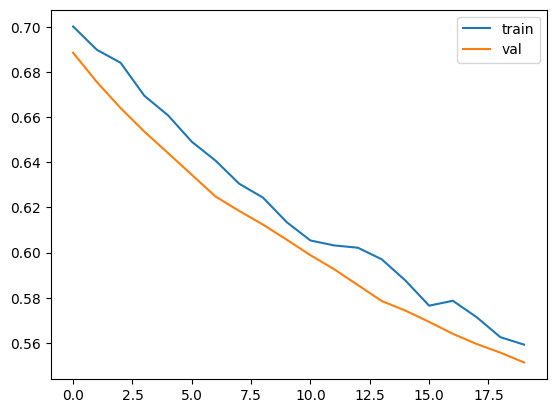

In [24]:
plt.plot(train_loss_hist, label='train')
plt.plot(val_loss_hist, label='val')
plt.legend()

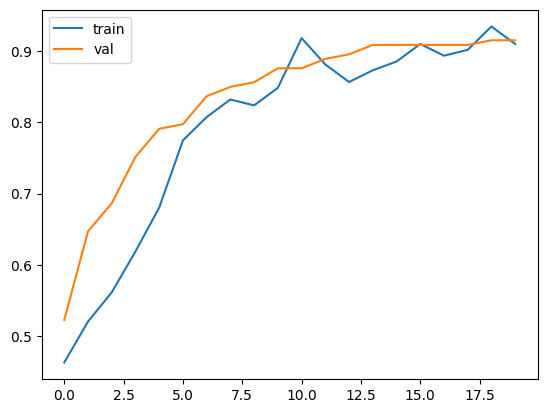

In [25]:
plt.plot(train_acc_hist, label='train')
plt.plot(val_acc_hist, label='val')
plt.legend()